In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
ticker = "^GSPC"
start_date = "2018-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
sp500_data = yf.download(ticker, start=start_date, end=end_date)
log_sp500 = np.log(sp500_data['Adj Close'])
# Calculate log returns of adjusted close price
sp500_data['Log_Return'] = log_sp500 - log_sp500.shift(1)
sp500_data.dropna(inplace=True)
sp500_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Log_Return
Date,,,,,,,
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000,0.006378
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000,0.004021
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000,0.007009
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000,0.001661
2018-01-09,2751.149902,2759.139893,2747.860107,2751.290039,2751.290039,3467460000,0.001302
...,...,...,...,...,...,...,...
2023-07-24,4543.390137,4563.410156,4541.290039,4554.640137,4554.640137,3856250000,0.004026
2023-07-25,4555.189941,4580.620117,4552.419922,4567.459961,4567.459961,3812470000,0.002811
2023-07-26,4558.959961,4582.470215,4547.580078,4566.750000,4566.750000,3990290000,-0.000155


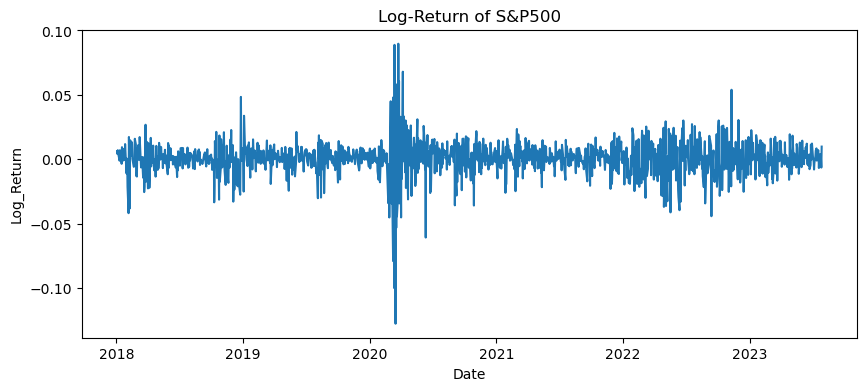

In [3]:
log_return = sp500_data['Log_Return']
plt.figure(figsize=(10,4))
plt.plot(log_return)
plt.xlabel('Date')
plt.ylabel('Log_Return')
plt.title('Log-Return of S&P500')
plt.show()

In [4]:
warnings.filterwarnings("ignore")
prediction = []
forecast = []
fail = {}
test = 252
for i in range(test):
    train = log_return.iloc[i:-test+i]
    #AIC Based ARIMA model selection
    final_aic = float('inf')
    for p in range(7):
        for d in range(3):
            for q in range(7):
                if p==0 and q==0:
                    continue
                try:
                    # Fit ARIMA model
                    model_fit = ARIMA(train, order=(p,d,q)).fit()
                except:
                    continue

                current_aic = model_fit.aic
                if current_aic<final_aic:
                    final_aic = current_aic
                    final_arima = model_fit
    residuals = final_arima.resid
    box_test_result  = acorr_ljungbox(residuals,lags=20,return_df=True)
    if box_test_result.iloc[-1]['lb_pvalue']>0.05:
        #AIC based GARCH Model Selection and fitting:
        vol_aic = float('inf')
        for p_garch in range(6):
            for o in range(1,3):
                for q_garch in range(6):
                    if p==0 and q==0:
                        continue
                    try:
                        vol_model = arch_model(train,mean='Zero',vol='GARCH',p=p_garch,o=o,q=q_garch,dist='ged').fit(disp='off',show_warning=False)
                    except:
                        continue    
                    if vol_model.aic<vol_aic:
                        vol_aic = vol_model.aic
                        final_vol_model = vol_model
        #Parameters for Laplace Distribution:
        loc = 0
        scale = np.sqrt(0.5)                
        #Prediction with ARIMA+TGARCH
        predicted_mu = final_arima.forecast(steps=1).iloc[0]
        garch_forecast = final_vol_model.forecast(horizon=1)
        predicted_et = np.sqrt(garch_forecast.variance['h.1'].iloc[-1])*np.random.laplace(loc=loc,scale=scale)
        final_prediction = predicted_mu+predicted_et
        forecast.append(final_prediction)
        if final_prediction>0:
            prediction.append(1)
        elif final_prediction<0:
            prediction.append(-1)    
    else:
        print(f'could not fit ARIMA on {log_return.index[i-test]}')
        fail[log_return.index[i-test]] = 1

In [5]:
prediction_series = pd.Series(prediction,index = log_return.index[-test:])
prediction_series.name = 'Forecast'
prediction_series

Date
2022-07-28   -1
2022-07-29   -1
2022-08-01    1
2022-08-02   -1
2022-08-03    1
             ..
2023-07-24   -1
2023-07-25    1
2023-07-26    1
2023-07-27    1
2023-07-28    1
Name: Forecast, Length: 252, dtype: int64

To make prediction series compatible with Zipline event based strategy we do backward shift of our prediction.

In [10]:
test_pred = prediction_series.shift(-1)
test_pred.dropna(inplace=True)
test_pred.to_csv('../../sp500_test_forecast.csv')